# Population Simulator

In [1]:
import random
from matplotlib import pyplot as plt
from collections import defaultdict

In [92]:
class Individual(object):
    """This class represents an individual."""

    def __init__(self, gamete1, gamete2, sex):
        """
        @param genes1: sequence of alleles on first "chromosome".
        Each allele is a symbol; typically an integer or a random string.
        @param genes2: sequence of alleles on second "chronosome". """
        self.chromosomes = list(zip(gamete1, gamete2))
        self.sex = sex

    @staticmethod
    def create_random(num_genes=1, num_alleles=2, mu=0, highest_allele=1, sex_ratio=0.5):
        genes = [[random.randint(0, num_alleles - 1) for _ in range(num_genes)] for g in range(2)]
        for gene in range(len(genes)):
            for allele in range(len(genes[gene])):
                # maybe mutate
                if random.random() < mu:
                    genes[gene][allele] = round(random.random() * highest_allele)
        
        gene1, gene2 = genes
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(gene1, gene2, sex)

    def gamete(self, highest_allele, mu):
        """Returns random gamete."""
        genes = [a[random.randint(0, 1)] for a in self.chromosomes]
        for gene in range(len(genes)):
            if random.random() < mu:
                genes[gene] = round(random.random() * highest_allele)
        return genes

    def __eq__(self, other):
        """Checks for genetic equality."""
        return self.chromosomes == other.chromosomes

    def __repr__(self):
        return str(self.chromosomes)

class Genotype():
    def __init__(self, gene_index, gene):
        self.gene_index = gene_index
        self.gene = gene

    def __repr__(self):
        # gene index = letter, gene # = number
        return f'({chr(self.gene_index + 97)}{self.gene[0]},{chr(self.gene_index + 97)}{self.gene[1]})'

    def __eq__(self, other):
        """Checks for Genotype equality."""
        return self.gene_index == other.gene_index and self.gene == other.gene

    def __hash__(self):
        return hash((self.gene_index, self.gene))

    def get_allele(self, index):
        return Allele(self.gene_index, self.gene[index])

class Allele():
    def __init__(self, gene_index, allele):
        self.gene_index = gene_index
        self.allele = allele

    def __repr__(self):
        # gene index = letter, gene # = number
        return f'{chr(self.gene_index + 97)}{self.allele}'

    def __eq__(self, other):
        """Checks for Genotype equality."""
        return self.gene_index == other.gene_index and self.allele == other.allele

    def __hash__(self):
        return hash((self.gene_index, self.allele))

In [147]:
from collections import defaultdict
class Population(object):
    """This class represents the snapshot of a population."""

    def __init__(self, individuals=None, mu=0, highest_allele=1, unfitness_dict={}, multi_gene_unfitness_dict={}, ick_dict={}, bad_luck=0.01):
        self.individuals = individuals or []
        self.females, self.males = None, None
        self.gene_frequencies = []
        self.mu = mu
        self.highest_allele = highest_allele
        self.unfitness_dict = unfitness_dict
        self.multi_gene_unfitness_dict = multi_gene_unfitness_dict
        self.ick_dict = ick_dict
        self.bad_luck = bad_luck

    def __len__(self):
        return len(self.individuals)

    def __iter__(self):
        return iter(self.individuals)

    def is_monozygotic_for(self, gene):
        """ Returns TRUE if this gene is monozygotic; else FALSE """
        return self.chromosomes[gene][0] == self.chromosomes[gene][1]

    def add(self, individual):
        self.individuals.append(individual)

    def pick_individual(self):
        """Returns a random individual."""
        return random.choice(self.individuals)

    '''
    Selects individual based on their fitness
    param mating_bias_dict: maps genotypes to their chance of getting them unselected for mating
    '''
    def pick_individual_selectively(self):
        """Returns a random individual."""
        while True:
            ick = 0
            ind = random.choice(self.individuals)
            for genotype, badness in self.ick_dict.items():
                if ind.chromosomes[genotype.gene_index] == genotype.gene:
                    ick += badness
            x = random.random()
            if random.random() > ick:
                return ind

    def random_mating(self, sex_ratio=0.5):
        """Returns an individual produced via random mating."""
        g1 = self.pick_individual().gamete(self.highest_allele, self.mu)
        g2 = self.pick_individual().gamete(self.highest_allele, self.mu)
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(g1, g2, sex)

    def selective_random_mating(self, sex_ratio=0.5):
        """Returns an individual produced via random mating."""
        g1 = self.pick_individual_selectively().gamete(self.highest_allele, self.mu)
        g2 = self.pick_individual_selectively().gamete(self.highest_allele, self.mu)
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(g1, g2, sex)

    def random_hermaphrodite_mating(self, sex_ratio):
        """Returns an individual generated via non-self mating,
        aka Banana Slug mating."""
        i1, i2 = random.sample(self.individuals, k=2)
        g1 = i1.gamete(self.highest_allele, self.mu)
        g2 = i2.gamete(self.highest_allele, self.mu)
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(g1, g2, sex)

    def partition_genders_randomly(self, prob=0.5):
        """Partition the population in genders, randomly.
        Returns whether there is at least somebody of both genders."""
        self.males, self.females = [], []
        for x in self.individuals:
            if random.random() < prob:
                self.females.append(x)
            else:
                self.males.append(x)
        return len(self.females) > 0 and len(self.males) > 0

    def random_sexual_mating(self, prob=0.5, sex_ratio=0.5):
        """This is a simple model, in which mating can happen only between
        individuals of opposite sex, and we are given the probability that an
        individual is of a given sex.
        We could do things in another way, but this is ok for now."""
        if self.females is None and self.males is None:
            feasible = self.partition_genders_randomly(prob=prob)
            if not feasible:
                return None
        f = random.choice(self.females)
        m = random.choice(self.males)
        f_gamete = f.gamete(self.highest_allele, self.mu)
        m_gamete = m.gamete(self.highest_allele, self.mu)

        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(f_gamete, m_gamete, sex)

    def get_generation(self, method, highest_allele, mu, pop_size=None, *args, **kwargs):
        """Gets a new generation according to the given method."""
        if pop_size == None:
            pop_size = len(self.individuals)

        # EVOLUTION HAPPENS HERE BASED ON GENE FITNESS:
        # for each individual, calculate its chance of death due to bad genes and add to surviving_population
        surviving_population = []
        for ind in self.individuals:
            avg = 0
            for genotype, badness in self.unfitness_dict.items():
                if ind.chromosomes[genotype.gene_index] == genotype.gene:
                    avg += badness
            death_chance = self.bad_luck + (avg / len(ind.chromosomes))

            # now check multi-gene fitness:
            # { [gene1, gene2]: 0.2 }
            for gene_list, unfitness in self.multi_gene_unfitness_dict.items():
                has_all = True
                for gene in gene_list:
                    if ind.chromosomes[gene.gene_index] != gene.gene:
                        has_all = False
                if has_all:
                    death_chance = self.bad_luck + unfitness

            # simulate death
            x = random.random()
            if x > death_chance:
                surviving_population.append(ind)



        self.individuals = surviving_population

        new_pop = [method(self, *args, **kwargs) for _ in range(pop_size)]

        return Population(new_pop, highest_allele=self.highest_allele, mu=mu, unfitness_dict=self.unfitness_dict, multi_gene_unfitness_dict=self.multi_gene_unfitness_dict, ick_dict=self.ick_dict, bad_luck=self.bad_luck)


    def __repr__(self):
        """You can improve this..."""
        return "\n".join([str(i) for i in self.individuals])

    '''
    Caluclate actual F based on the fraction of hetero vs homo alleles in gene_frequencies
    '''
    def calculate_F_heterozygote(self):
        N = len(self.individuals)
        allele_counts = defaultdict(int)
        for i in self.individuals:
            for chromosome in i.chromosomes:
                sorted_chromosome = str(sorted(chromosome))
                allele_counts[sorted_chromosome] += 1
        obs_homo = 0
        for allele in allele_counts:
            if (len(set(allele)) == len(allele)):
                obs_homo += (allele_counts[allele] / 2*N)**2
        exp_het = 1-obs_homo
        return (obs_homo) * -1

    def get_estimated_fst(self, f_ls):
        N = len(self.individuals)
        return 1/(2*N) + (1-(1/(2*N))) * f_ls[-1] if len(f_ls) >= 1 else 0

    def get_unique_alleles(self):
        return self.highest_allele

    def get_K(self):
        return (1 + 4 * len(self.individuals)) / self.mu

    '''
    returns a dict of genes to their frequency seen
    param genotype_count: if none make a new count dict, if given add to current one
    '''
    def get_genotype_frequencies(self, gene_index=None, genotype_count=None):
        if not genotype_count:
            genotype_count = defaultdict(lambda:0)

        for i in self.individuals:
            gene_indices = [gene_index] if gene_index is not None else range(len(i.chromosomes))
            for gene_ind in gene_indices:
                genotype = Genotype(gene_ind, i.chromosomes[gene_ind])
                genotype_count[genotype] += 1
        return genotype_count

    def alleleCount(self):
        """Return the count of distinct alleles present in the population"""
        return len(set().union([x.chromosomes[0][i] for x in self.individuals for i in [0,1]]))

In [4]:
import numpy as np
def normalize(arr):
    x = np.array(arr)
    x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
    return list(x_norm)

In [131]:
import matplotlib.pyplot as plt
import numpy as np

'''
draws a histogram of genotype frequency in the current population
'''
def draw_frequency_histogram(freq_dict):
    plt.bar(list(freq_dict.keys()), freq_dict.values(), color='b')
    plt.show()

'''
Gets a list of frequency over time for all genes to ever be present in the population

param all_genes_seen: list of all genes seen over time of population
param gene_frequencies: list of gene frequency dictionaries for each generation
returns: dictionary mapping genes to a list of their frequency in each generation, where list index = generation
'''
def get_temporal_frequency(all_genes_seen, gene_frequencies, filter_out_percent=0.0):
    gene_freqs_over_time = defaultdict(lambda:[])
    gene_freqs_over_time_sums = defaultdict(lambda:[])

    for gene in all_genes_seen:
        for generation in gene_frequencies:
            gene_freqs_over_time[gene].append(0 if not generation.get(gene) else generation.get(gene))

    # filter out least frequent {filter_out_percent}% of genes
    if filter_out_percent > 0:
        for gene, freqs in gene_freqs_over_time.items():
            gene_freqs_over_time_sums[gene] = np.sum(np.array(freqs))
        gene_freqs_over_time_sums_sorted = sorted(gene_freqs_over_time_sums.keys(), key=lambda item: item[1],reverse=True)
        gene_freqs_over_time_filtered_keys = gene_freqs_over_time_sums_sorted[0: int(len(gene_freqs_over_time_sums_sorted) * (1-filter_out_percent))]
        gene_freqs_over_time = {key: gene_freqs_over_time[key] for key in gene_freqs_over_time_filtered_keys}
    return dict(gene_freqs_over_time)

'''
param gene_freqs_over_time: dict mapping genes to a list of their frequency in each generation, where list index = generation
'''
def get_allele_freq_over_time(gene_freqs_over_time):
    allele_freqs_over_time = {}
    for gene, freqs in gene_freqs_over_time.items():
        for i, allele in enumerate(gene.gene):
            if gene.get_allele(i) not in allele_freqs_over_time.keys():
                allele_freqs_over_time[gene.get_allele(i)] = freqs
            else:
                allele_freqs_over_time[gene.get_allele(i)] = np.array(allele_freqs_over_time.get(gene.get_allele(i))) + np.array(freqs) 

    return allele_freqs_over_time

'''
TODO: add gene_index
Plots the temporal frequencies of all genes to be present in the population
param gene_freqs_over_time: dictionary mapping genes to a list of their frequency in each generation, where list index = generation
'''
def plot_freqs_over_time(gene_freqs_over_time, special={}, figsize=(12, 6), fontsize="6", title='Genotype frequency over time', gene_index=None):
    # plot lines
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    default_special_line_styles={
        0: '-',
        1: '--',
        2: '-.',
        3: ':',
        4: '.',
        5: '..'
        }

    for gene, freqs in gene_freqs_over_time.items():
        identifier = gene.gene if type(gene) == Genotype else gene.allele
        if (identifier in special.keys()):
            ax.plot(freqs, label = gene, color=special[identifier], linestyle=default_special_line_styles[gene.gene_index] if gene not in special.keys() else special[gene])
        else:
            ax.plot(freqs, label = gene, linestyle=default_special_line_styles[gene.gene_index] if gene not in special.keys() else special[gene])

    plt.title(title);
    plt.xlabel('Generations')
    plt.ylabel('Frequency')

    ax.legend(fontsize=fontsize)

def run_simulation(num_genes=1, mu=0, pop_size = 100, generations=1000, simulations=10, bad_luck=0.01, unfitness_dict={}, multi_gene_unfitness_dict={}, ick_dict={}, mating=Population.selective_random_mating, special={}, num_starting_alleles=2, highest_allele=10, gene_index=None, figsize=(12,6), fontsize='8'):
    gene_frequencies = [[] for gen in range(generations)]
    all_genes_seen = []

    for sim in range(simulations):
        init_pop = [Individual.create_random(num_genes=num_genes, mu=mu, highest_allele=highest_allele, num_alleles=num_starting_alleles) for _ in range(pop_size)]
        pop = Population(init_pop, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict=ick_dict, highest_allele=highest_allele, bad_luck=bad_luck)
        for gen in range(generations):
            pop = pop.get_generation(Population.selective_random_mating, highest_allele=pop.highest_allele, mu=mu)

            freq = pop.get_genotype_frequencies(gene_index, gene_frequencies[gen])
            gene_frequencies[gen] = freq

            all_genes_seen = list(set(all_genes_seen + list(freq.keys())))

    gene_freqs_over_time = get_temporal_frequency(all_genes_seen, gene_frequencies, filter_out_percent=0)

    for gen, freqs in gene_freqs_over_time.items():
        gene_freqs_over_time[gen] = np.array(freqs) / simulations

    plot_freqs_over_time(gene_freqs_over_time, special=special, figsize=figsize, fontsize=fontsize)
    return gene_freqs_over_time

# Part 1: Frequency of bad alleles
### Model where (1,1) is more or less as good as (1,0), but (0,0) is quite bad. What’s the percentage of non-1?  How is that related to the bad luck probability?

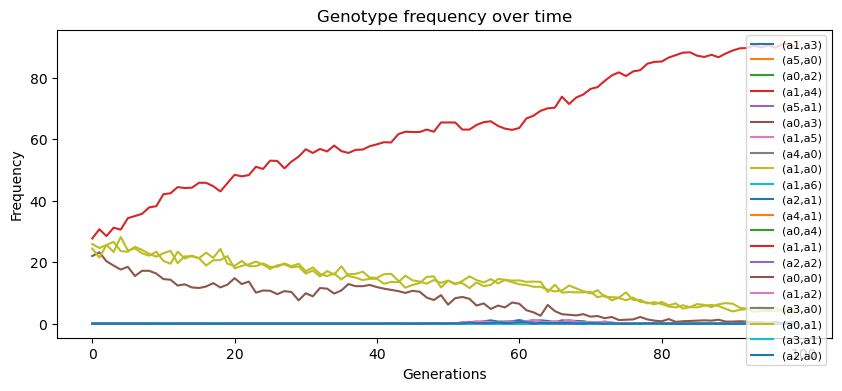

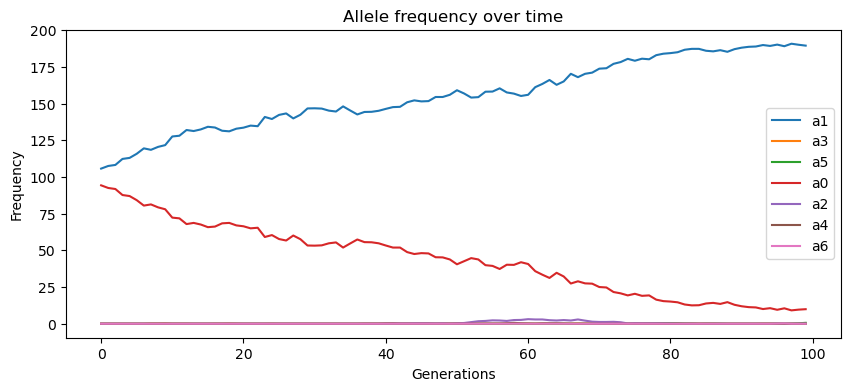

In [85]:
''' 
Experiment: What if one allele is relatively good while all others are bad. What’s the percentage of non-good?  How is that related to the bad luck probability? 
Setup: anything with allele a1 is relatively good (10% death), whereas all other pairs are worse (20% death), and we have bad luck of (1% random death)
------------------------------------------------------------
FINDINGS: When one allele is particularly good in comparison to all others, very soon converges towards homozygote of that allele
'''

bad_luck = 0.01

unfitness_dict = {
    Genotype(0, (0,0)): 0.2,  # 00 quite bad
    Genotype(0, (1,0)): 0.1,  # 10 not bad
    Genotype(0, (0,1)): 0.1,  # 01 not bad
    Genotype(0, (1,1)): 0.1,  # 11 not bad
}

for i in range(10):
    for j in range(10):
        g = Genotype(0, (i,j))
        if j == 1 or i == 1:
            unfitness_dict[g] = 0.1
        else:
            unfitness_dict[g] = 0.2

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=1, mu=0.0001, pop_size=100, generations=100, simulations=10, bad_luck=bad_luck, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4))
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

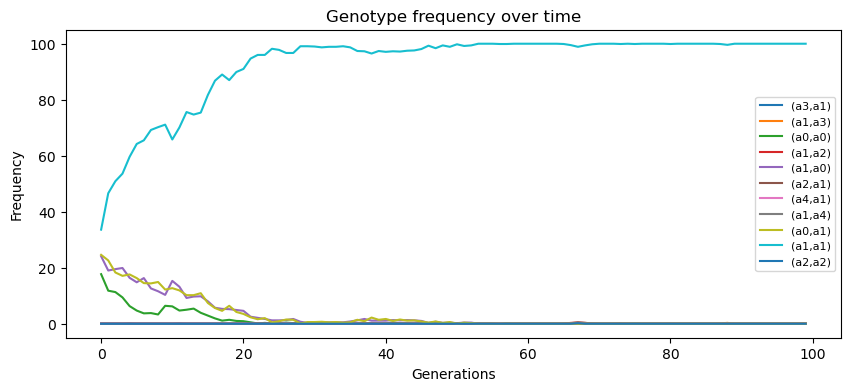

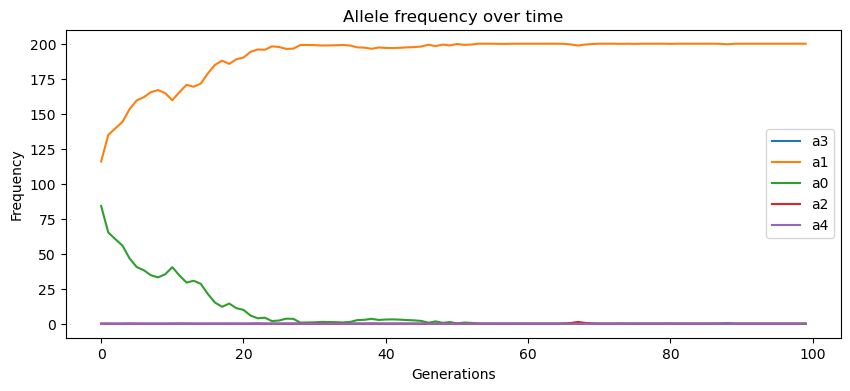

In [48]:
''' 
Same as above: anything with allele a1 is relatively good, but we have bad luck of 0.7 (70% random death)
------------------------------------------------------------
FINDINGS: Bad luck seems to increase the rate with which converges to homozygote 'good' allele
'''

bad_luck = 0.7
unfitness_dict = {
    Genotype(0, (0,0)): 0.2,  # 00 quite bad
    Genotype(0, (1,0)): 0.1,  # 10 not bad
    Genotype(0, (0,1)): 0.1,  # 01 not bad
    Genotype(0, (1,1)): 0.1,  # 11 not bad
}

for i in range(10):
    for j in range(10):
        g = Genotype(0, (i,j))
        if j == 1 or i == 1:
            unfitness_dict[g] = 0.1
        else:
            unfitness_dict[g] = 0.2

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=1, mu=0.0001, pop_size=100, generations=100, simulations=10, bad_luck=bad_luck, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4))
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

# Part 2 - Evolution of positive mutations:
### Is it true that sexual reproduction speeds up evolution, by fastening the time required for generating an individual that accumulates more than one (say, two or three) positive unrelated mutations?

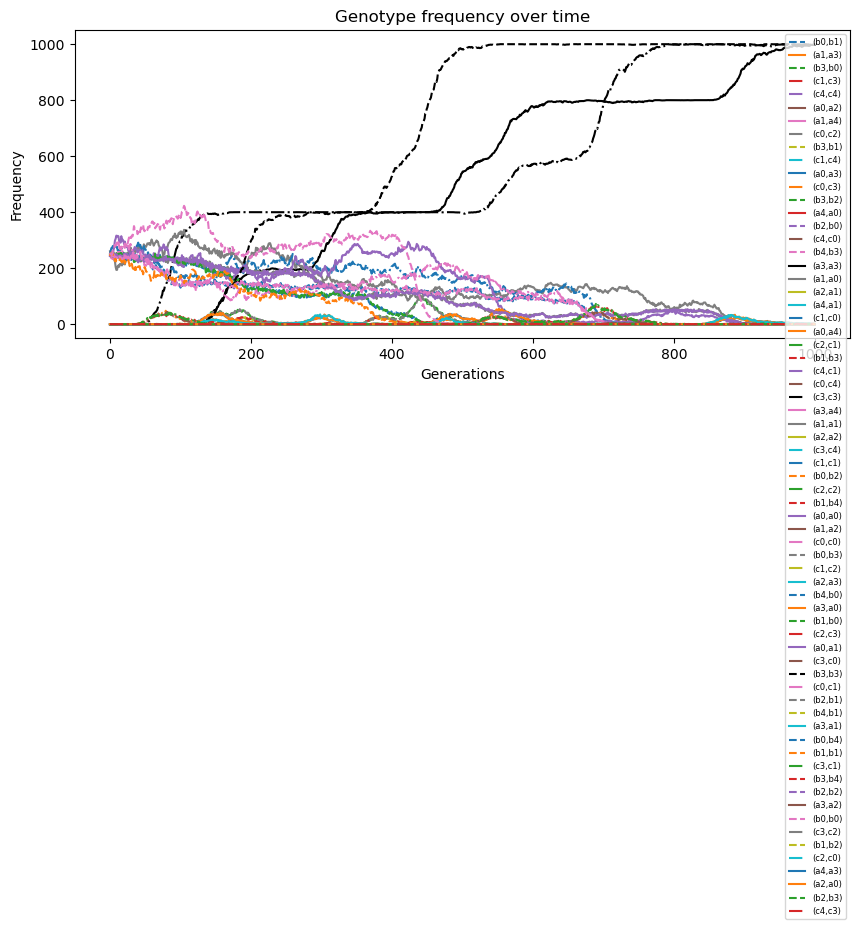

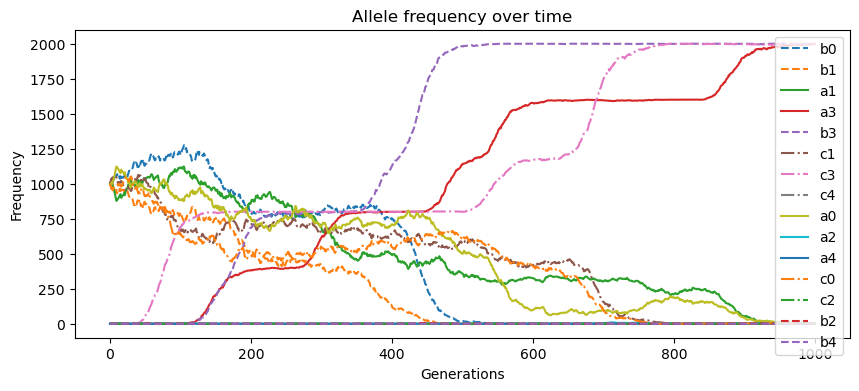

In [123]:
''' 
Experiment: If there is a positive mutation in all 3 genes, how long does it take for the population to converge to all the positive mutations?
Setup: 3 is our positive mutation. heterozygotes with 3 are a bit better than without. homozygote 33 is much better than heterozygotes with 3 or otherwise. And similarly for all genes. 
------------------------------------------------------------
FINDINGS: When one homogenous gene is particularly bad in comparison to all other genes, gene converges towards the other homogenous gene within 1000 gens
'''

unfitness_dict = {}
for gene_index in range(3):
    for i in range(10):
        for j in range(10):
            g = Genotype(gene_index, (i,j))
            # if we have heterogeneous with allele 3, not bad
            if j == 3 and i == 3:
                unfitness_dict[g] = 0.02
            elif j == 3 or i == 3:
                unfitness_dict[g] = 0.05
            # otherwise not good
            else:
                unfitness_dict[g] = 0.15

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=3, mu=0.00002, pop_size=1000, generations=1000, simulations=5, highest_allele=4, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

# Part 3 - Evolution of positive mutations:
### Can sexual reproduction enable the conjunction of two mutations, each of which in isolation is unfavorable, but the two of which together are highly favorable?  That is, can sexual reproduction enable jumping co-evolution barriers?

Can you find interesting results? Can you show that sexual reproduction allows the survival of enough Aa, Bb, to make the aa, bb individual arise? Is it plausible that sexual reproduction allows the crossing of boundaries where you need two genes to evolve together to get a clear fitness advantage? 

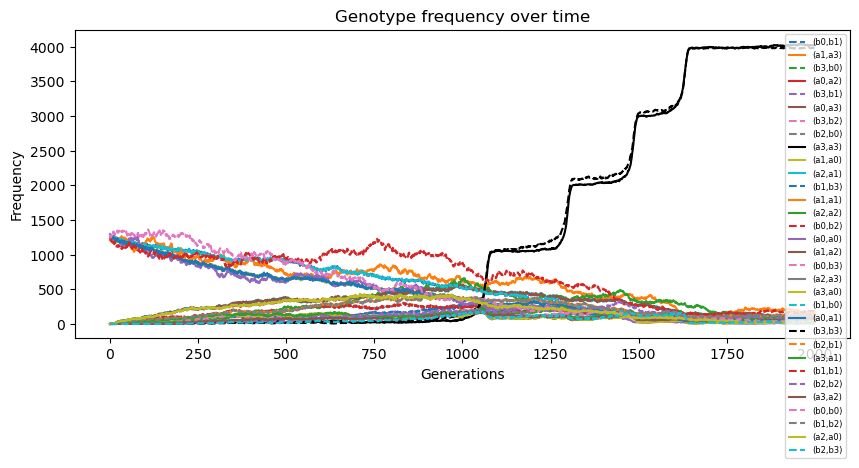

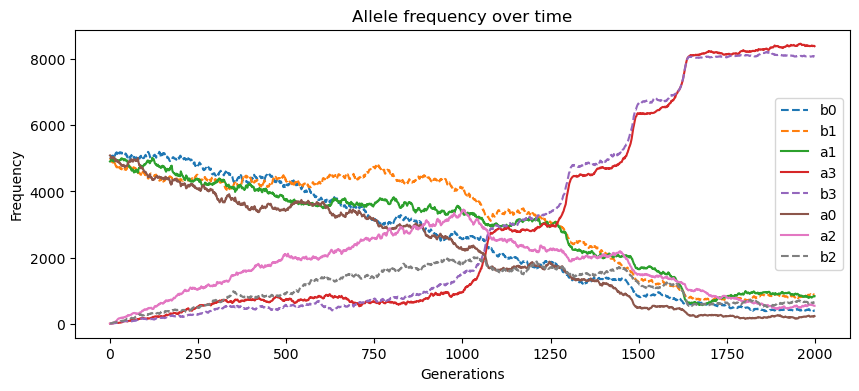

In [185]:
''' 
Testing multi-gene fitness: if there's higher fitness of 2 genotypes only when paired together
Setup: 3 is our positive mutation in both genes. All genes have 30% death, except 33 in gene 1 when paired with 33 in gene 2, yields only 2% death
------------------------------------------------------------
FINDINGS: Once mutation 33 appears in both genes, 33 comes to dominate for both genes within 2000 gens
'''
unfitness_dict={}
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            unfitness_dict[g] = 0.3

multi_gene_unfitness_dict = {
    (Genotype(0, (3,3)), Genotype(1, (3,3))): 0.02, # BEST PAIR
}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.001, pop_size=5000, generations=2000, simulations=5, highest_allele=3, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

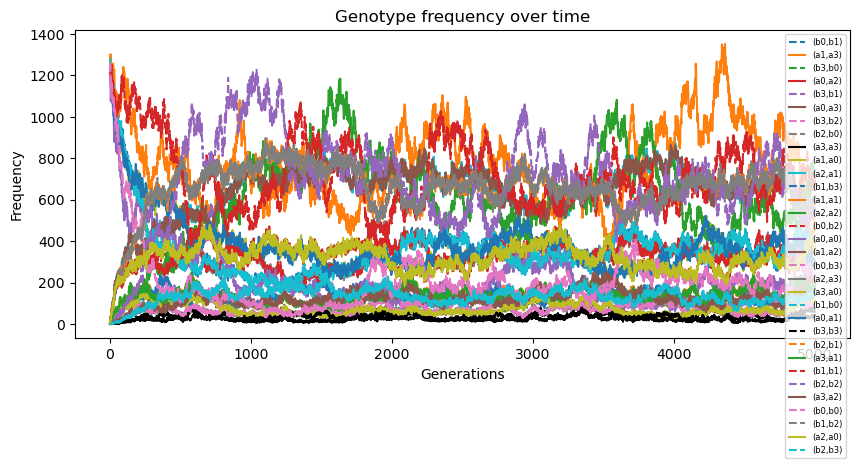

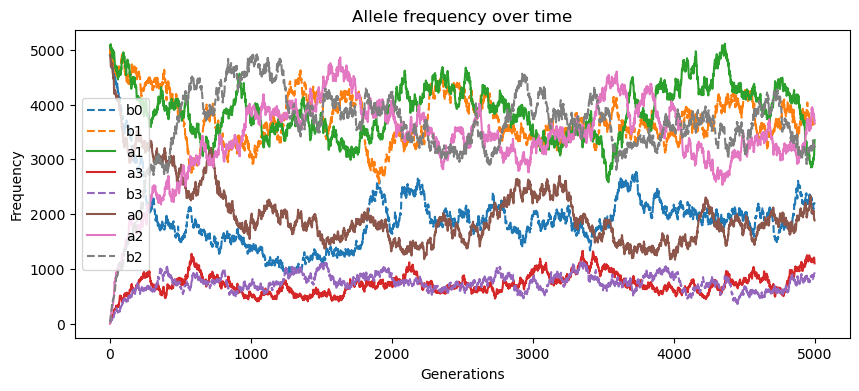

In [190]:
''' 
Experiment: See if both genes converge to the good-when-together mutations if the mutation is worse alone 
Setup: non-3 genes have 29% death, 3-having genes have 30% death (so (3,3) and 3 genes are worse by ONLY 0.01). But when both genes are 33, 2% death
------------------------------------------------------------
FINDINGS: 33 remains low/extinct in both genes
'''

unfitness_dict = {}
genes = []
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            genes.append(g)
            if g.gene == (3,3):
                unfitness_dict[g] = 0.3     # worst
            elif 3 in g.gene:
                unfitness_dict[g] = 0.3     # mid
            else:
                unfitness_dict[g] = 0.29      # not too bad

multi_gene_unfitness_dict = {
    (Genotype(0, (3,3)), Genotype(1, (3,3))): 0.02, # BEST PAIR
}

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.005, pop_size=5000, generations=5000, simulations=2, highest_allele=3, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

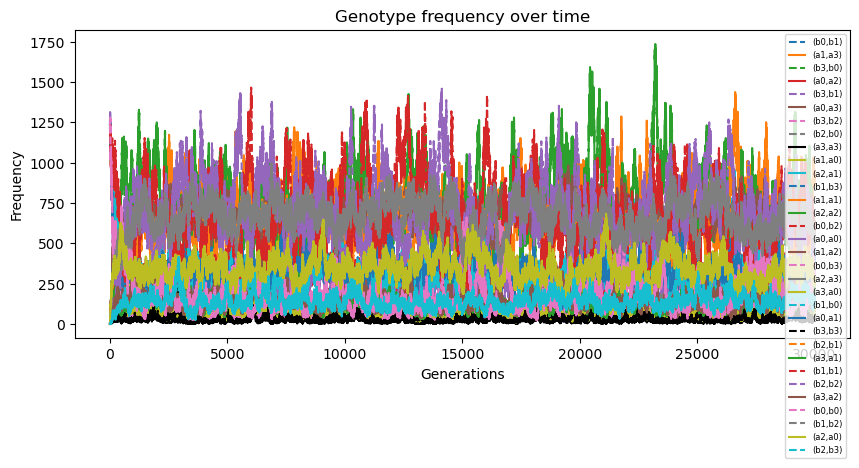

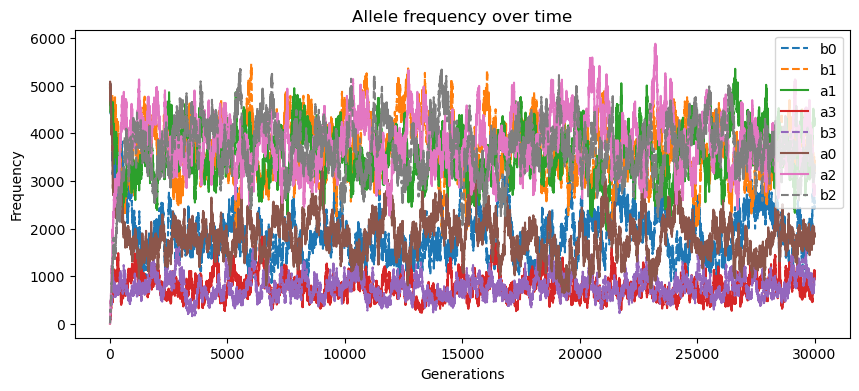

In [192]:
''' 
Experiment: Same as above, over 30,000 generations instead of 5000 to see if mutation needs more time...
Setup: non-3 genes have 29% death, 3-having genes have 30% death (so (3,3) and 3 genes are worse by ONLY 0.01). But when both genes are 33, 2% death (just over 30,000 generations)
------------------------------------------------------------
FINDINGS: 33 still remains low/extinct in both genes even over 30,000 generations
'''

unfitness_dict = {}
genes = []
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            genes.append(g)
            if g.gene == (3,3):
                unfitness_dict[g] = 0.3     # worst
            elif 3 in g.gene:
                unfitness_dict[g] = 0.3     # mid
            else:
                # unfitness_dict[g] = 0.15    # not too bad
                unfitness_dict[g] = 0.29      # not too bad

multi_gene_unfitness_dict = {
    (Genotype(0, (3,3)), Genotype(1, (3,3))): 0.02, # BEST PAIR
}

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.005, pop_size=5000, generations=30000, simulations=1, highest_allele=3, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

Experiment: Try with the same death rate for all genes except for multi-mutation pair to check that it would converge if 3 is equally weighted
Setup: all genes have 30% death. But when both genes are 33, 2% death
------------------------------------------------------------
FINDINGS: Quickly converges to 33 in both genes within 2000 generations

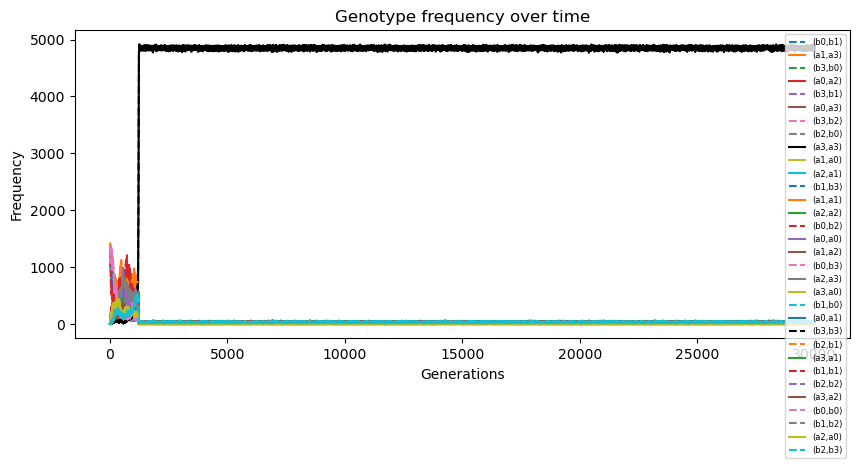

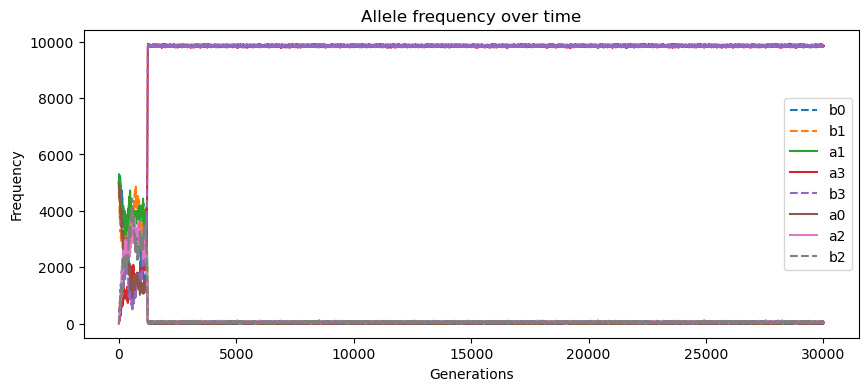

In [194]:
''' 
Experiment: Try with the same death rate for all genes except for multi-mutation pair to check that it would converge if 3 is equally weighted
Setup: all genes have 30% death. But when both genes are 33, 2% death
------------------------------------------------------------
FINDINGS: Quickly converges to 33 in both genes within 2000 generations
'''

unfitness_dict = {}
genes = []
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            genes.append(g)
            if g.gene == (3,3):
                unfitness_dict[g] = 0.3     # worst
            elif 3 in g.gene:
                # unfitness_dict[g] = 0.2     # mid
                unfitness_dict[g] = 0.3     # mid
            else:
                unfitness_dict[g] = 0.3      # not too bad

multi_gene_unfitness_dict = {
    (Genotype(0, (3,3)), Genotype(1, (3,3))): 0.02, # BEST PAIR
}

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.005, pop_size=5000, generations=30000, simulations=1, highest_allele=3, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

Experiment: See if both genes converge to the good-when-together mutations if the mutation is worse alone 
Setup: non-3 genes have 28% death, 3-having genes have 28% death, and 33 genes have 30% death. But when both genes are 33, 2% death (running now over 50,000 generations)
------------------------------------------------------------
FINDINGS: Does not converge :(

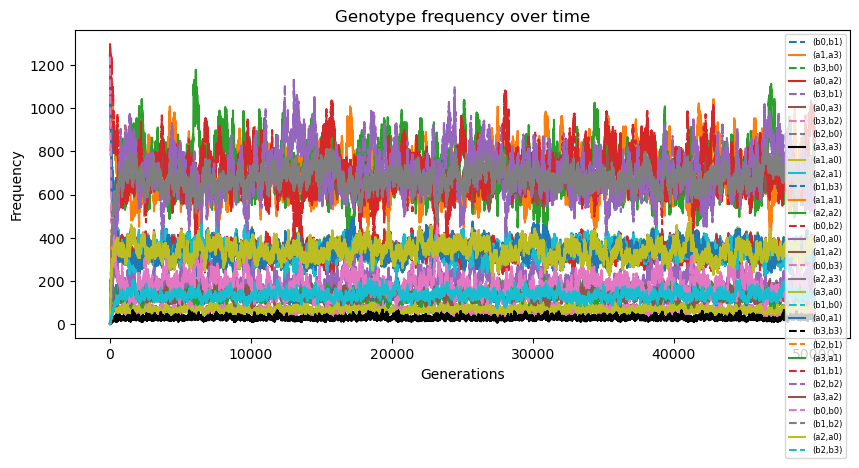

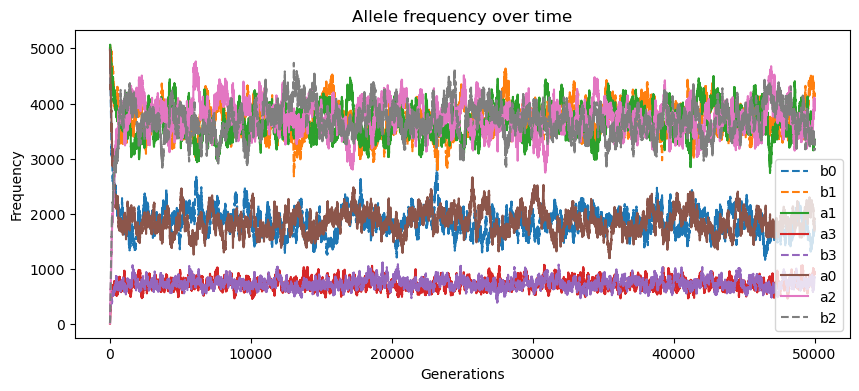

In [195]:
''' 
Experiment: See if both genes converge to the good-when-together mutations if the mutation is worse alone 
Setup: non-3 genes have 28% death, 3-having genes have 28% death, and 33 genes have 30% death. But when both genes are 33, 2% death (running now over 50,000 generations)
------------------------------------------------------------
FINDINGS: Does not converge :(
'''

unfitness_dict = {}
genes = []
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            genes.append(g)
            # 33 very bad
            if g.gene == (3,3):
                unfitness_dict[g] = 0.3     # worst
            # one 3 less bad
            elif 3 in g.gene:
                unfitness_dict[g] = 0.29     # mid
            # any non-3 is less bad
            else:
                unfitness_dict[g] = 0.28    # not too bad

multi_gene_unfitness_dict = {
    (Genotype(0, (3,3)), Genotype(1, (3,3))): 0.02, # BEST PAIR
}

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.005, pop_size=5000, generations=50000, simulations=5, highest_allele=3, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

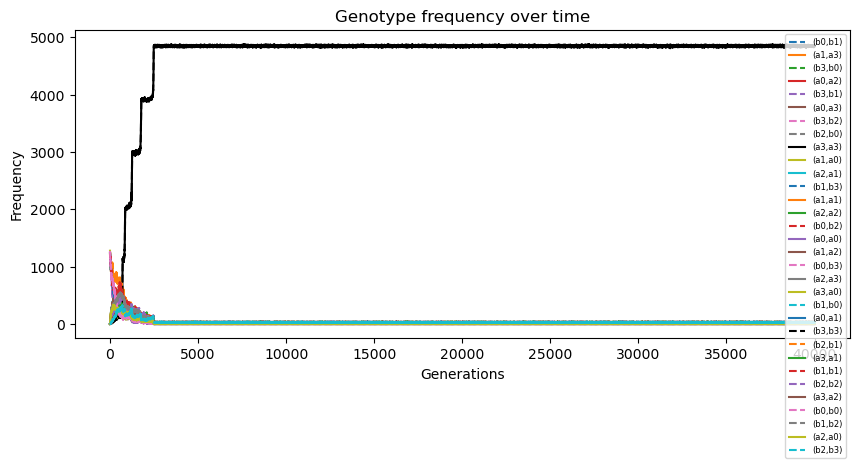

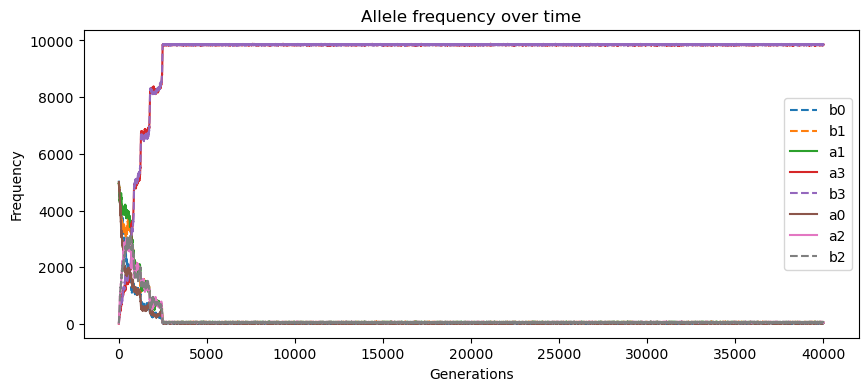

In [196]:
''' 
Experiment: See if both genes converge to the good-when-together mutations if the mutation is worse alone 
Setup: non-3 genes have 29% death, 3-having genes have 29% death too, and 33 genes have 30% death. But when both genes are 33, 2% death (running now over 40,000 generations)
------------------------------------------------------------
FINDINGS: converges to 33 mutation in both genes after ~4000 gens
    So then 3-having genes being worse than the alternative is what's holding back convergence on 33 in both genes?
'''

unfitness_dict = {}
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            # 33 very bad
            if g.gene == (3,3):
                unfitness_dict[g] = 0.3     # worst
            # one 3 less bad
            elif 3 in g.gene:
                unfitness_dict[g] = 0.29     # mid
            # any non-3 is less bad
            else:
                unfitness_dict[g] = 0.29    # not too bad

multi_gene_unfitness_dict = {
    (Genotype(0, (3,3)), Genotype(1, (3,3))): 0.02, # BEST PAIR
}

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.005, pop_size=5000, generations=40000, simulations=5, highest_allele=3, unfitness_dict=unfitness_dict, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

In [197]:
''' 
Experiment: See if both genes converge to the good-when-together mutations if the mutation is worse alone 
Setup: non-3 genes have 27% death, 3-having genes have 28% death, and 33 genes have 29% death. But when both genes are 33, 2% death (running now over 50,000 generations)
------------------------------------------------------------
FINDINGS: 
'''

unfitness_dict = {}
genes = []
for gene in range(2):
    for i in range(5):
        for j in range(5):
            g = Genotype(gene, (i,j))
            genes.append(g)

# make multi_gene_unfitness_dict for all pairs
multi_gene_unfitness_dict = {}
for g1 in genes:
    for g2 in genes:
        if g1.gene_index != g2.gene_index:
            if g1.gene == (3,3) and g2.gene == (3,3):
                multi_gene_unfitness_dict[g1, g2] = 0.02 # BEST PAIR
            elif g1.gene == (3,3) or g2.gene == (3,3):
                multi_gene_unfitness_dict[g1, g2] = 0.29 # BEST PAIR
            elif 3 in g1.gene or 3 in g2.gene:
                multi_gene_unfitness_dict[g1, g2] = 0.28 # BEST PAIR
            else:
                multi_gene_unfitness_dict[g1, g2] = 0.27 # BEST PAIR

special={(3, 3): 'k'}

# calculate genotype frequency
gene_freqs_over_time = run_simulation(num_genes=2, mu=0.005, pop_size=5000, generations=4000, simulations=5, highest_allele=3, unfitness_dict={}, multi_gene_unfitness_dict=multi_gene_unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, figsize=(10,4), fontsize='6', special=special)
# calculate allele frequency
allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,4), title='Allele frequency over time')

# Differences between mating preferences and survival chance
### What difference is there between genes that effect survivorship and genes that effect mating selection?
1. Is one more powerful than the other?
2. What if they're both in competition? (i.e. 'hold my beer' traits)

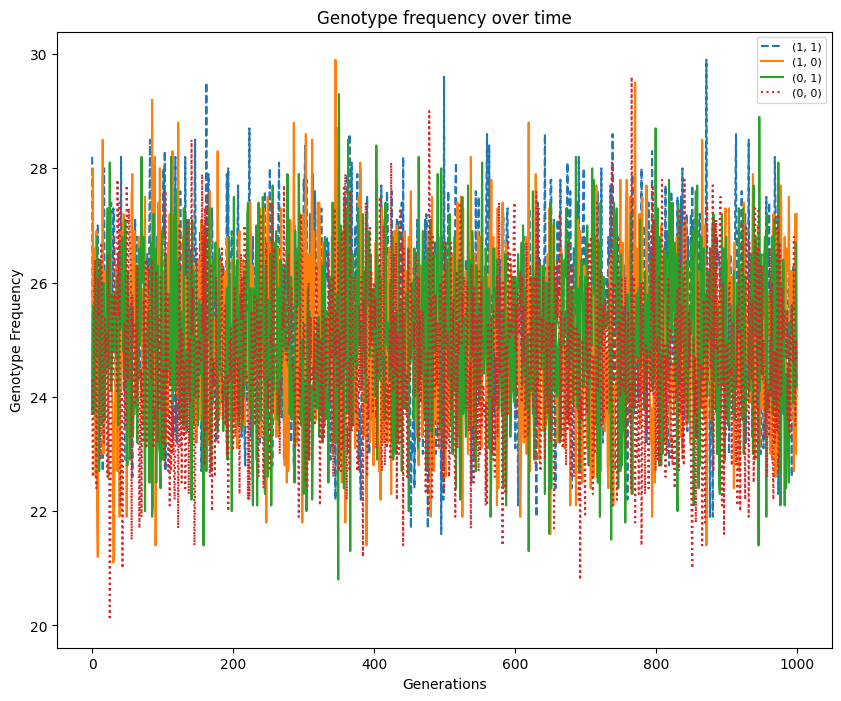

In [ ]:
# (0,0) is equally bad for survivorship as (1,1) is for mating
# So they're equally weighted?

unfitness_dict = {
    Genotype(0, (0,0)): 0.99, # (0,0) bad gene for survival
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.98, # (1,1) is bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=1000, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

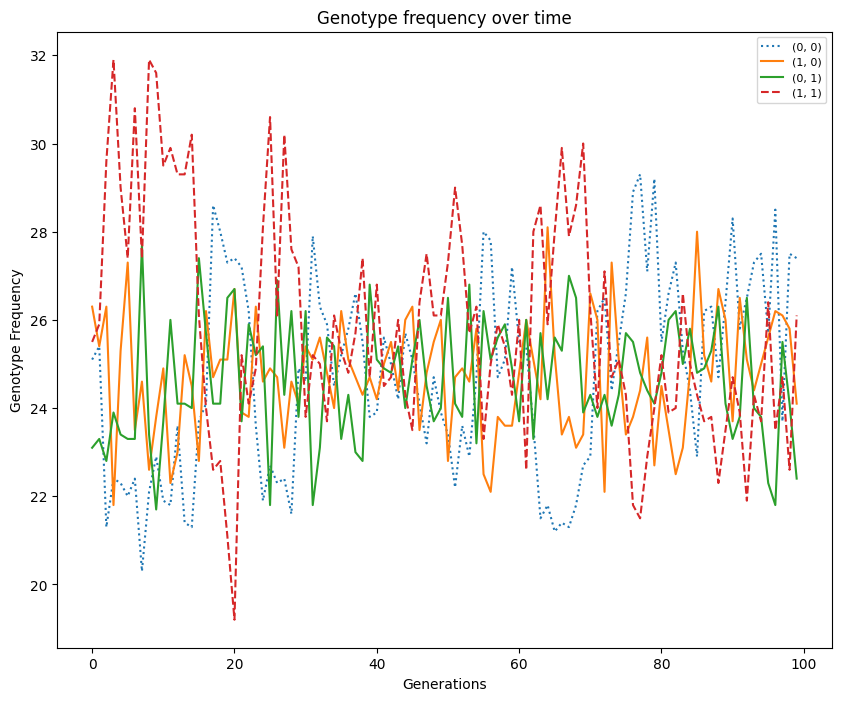

In [ ]:
# (0,0) is equally bad for survivorship as (1,1) is for mating
# So they're equally weighted?

unfitness_dict = {
    Genotype(0, (0,0)): 0.5, # (0,0) bad gene for survival
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.5, # (1,1) is bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

Evaluating unequal bias:

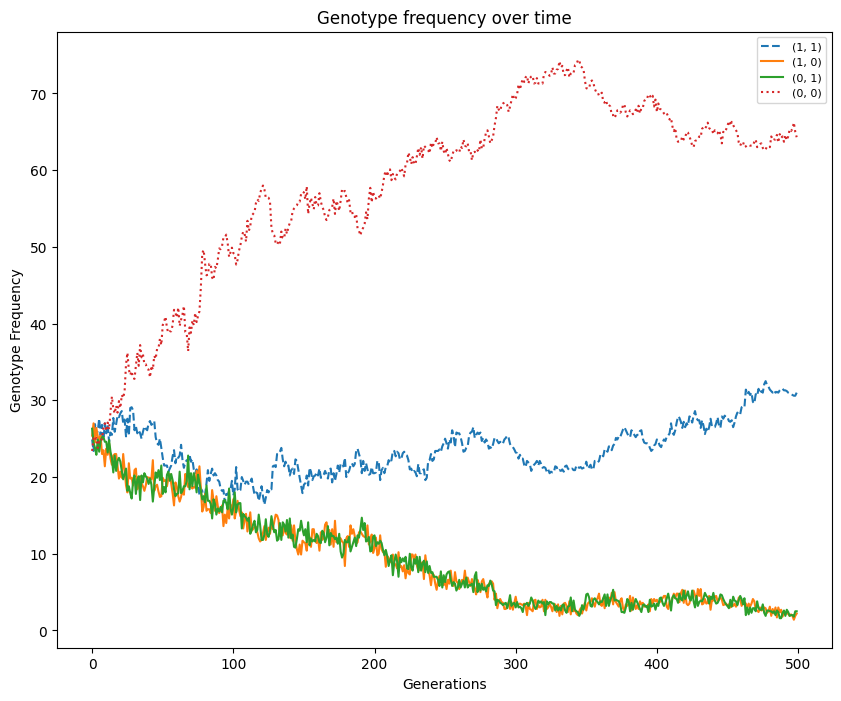

In [ ]:
'''
Heterozygotes die, homozygotes dont mate
FINDINGS: Doesn't fully converge but going towards homozygotes
'''

unfitness_dict = {
    Genotype(0, (0,0)): 0,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0,
    Genotype(0, (0,1)): 0,
    Genotype(0, (1,1)): 0.2,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=500, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

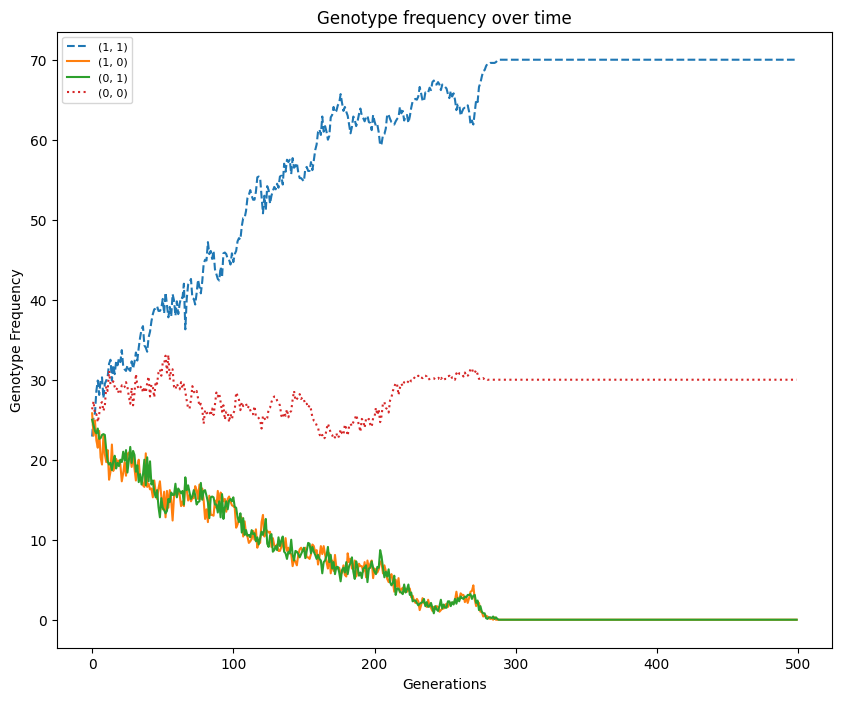

In [ ]:
'''
Heterozygotes dont mate, homozygotes die
FINDINGS: Converges to Homozygotes
'''
unfitness_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=500, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

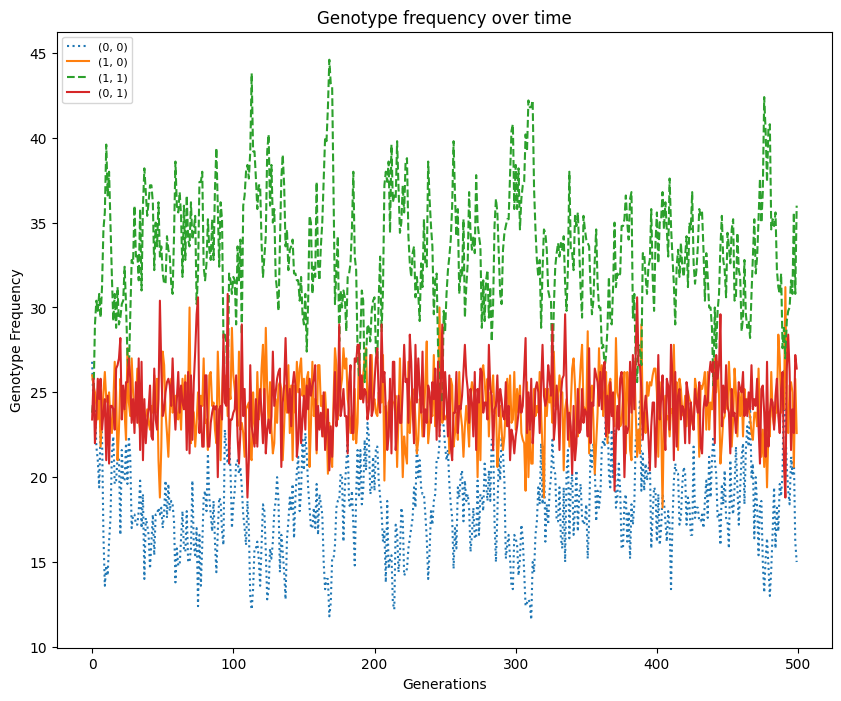

In [ ]:
'''
(0,0) is slightly worse for survivorship than (1,1) is for mating
FINDINGS: of course the less detremental one would persevere, but other doesnt die out - maybe because heterozygotes are best bet here?
'''
unfitness_dict = {
    Genotype(0, (0,0)): 0.5, # (0,0) is bad gene for survival
    Genotype(0, (1,0)): 0.1,
    Genotype(0, (0,1)): 0.1,
    Genotype(0, (1,1)): 0.1,
}
ick_dict = {
    Genotype(0, (0,0)): 0.1,
    Genotype(0, (1,0)): 0.1,
    Genotype(0, (0,1)): 0.1,
    Genotype(0, (1,1)): 0.4, # (1,1) is bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=500, simulations=5, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

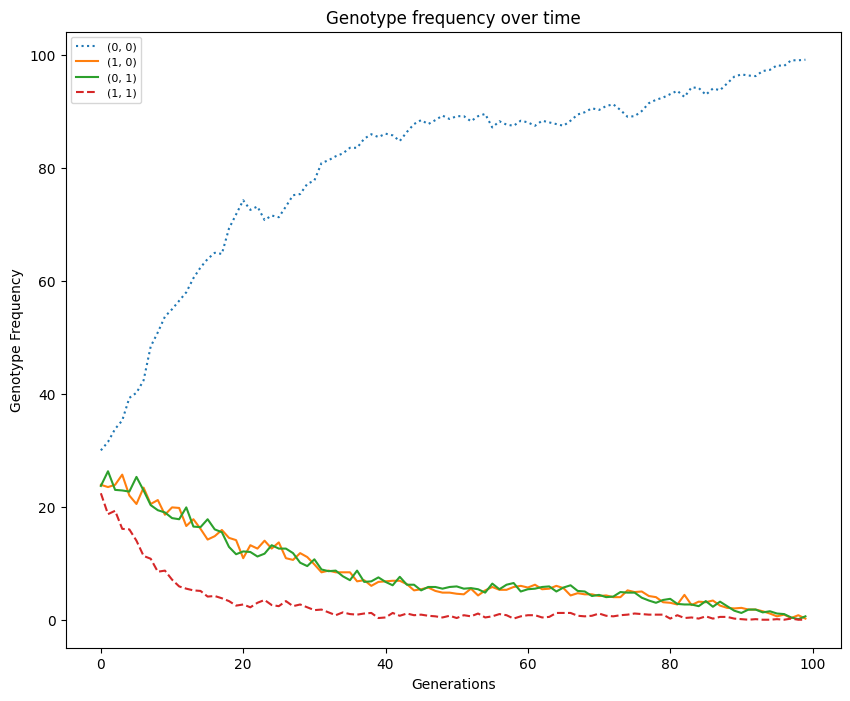

In [ ]:
'''
Any 0-having allele more likely to die than be chosen mate, but (1,1) not likely chosen to mate
FINDINGS: converge to (0,0) - likely to mate and still low chance of death
  Can we take this to the limit? at what point would converge to (1,1)?
'''
unfitness_dict = {
    Genotype(0, (0,0)): 0.1,
    Genotype(0, (1,0)): 0.1,
    Genotype(0, (0,1)): 0.1,
    Genotype(0, (1,1)): 0,
}
ick_dict = {
    Genotype(0, (0,0)): 0,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.3,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

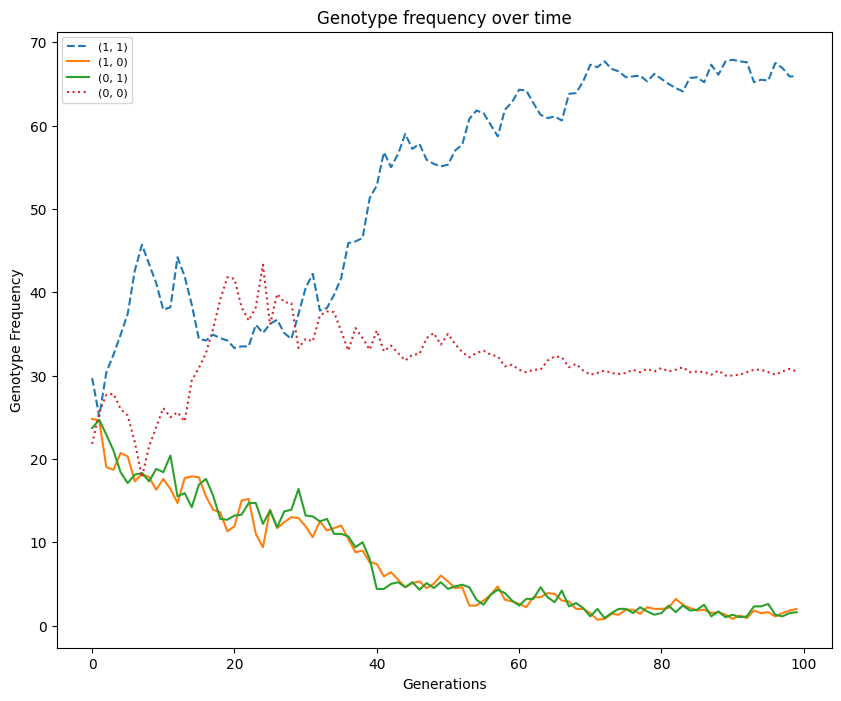

In [ ]:
'''
Above taken to the limit... (how bad does (0,0) have to get for (1,1) to be chosen? does it need to surpass (1,1)'s badness?)
Any 0-having allele more likely to die than be chosen mate, but (1,1) not likely chosen to mate
FINDINGS: Only at 0.89 does it converge (sometimes!) to (1,1) - likely to survive but low chance of mating
'''
unfitness_dict = {
    Genotype(0, (0,0)): 0.89,
    Genotype(0, (1,0)): 0.89,
    Genotype(0, (0,1)): 0.89,
    Genotype(0, (1,1)): 0,
}
ick_dict = {
    Genotype(0, (0,0)): 0,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.9,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

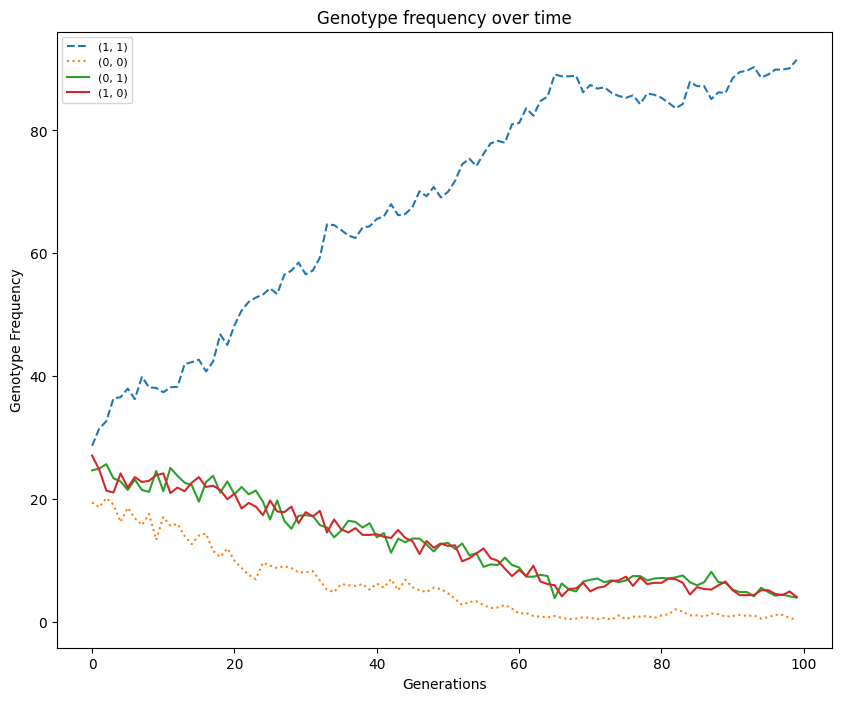

In [ ]:
'''
(0,0) is more prone to death, but (1,1) is not likely to reproduce
but here the death threat is slightly higher than reproductive
'''
unfitness_dict = {
    Genotype(0, (0,0)): 0.5, # bad gene for survival
    Genotype(0, (1,0)): 0.3,
    Genotype(0, (0,1)): 0.3,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.3,
    Genotype(0, (0,1)): 0.3,
    Genotype(0, (1,1)): 0.4, # bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

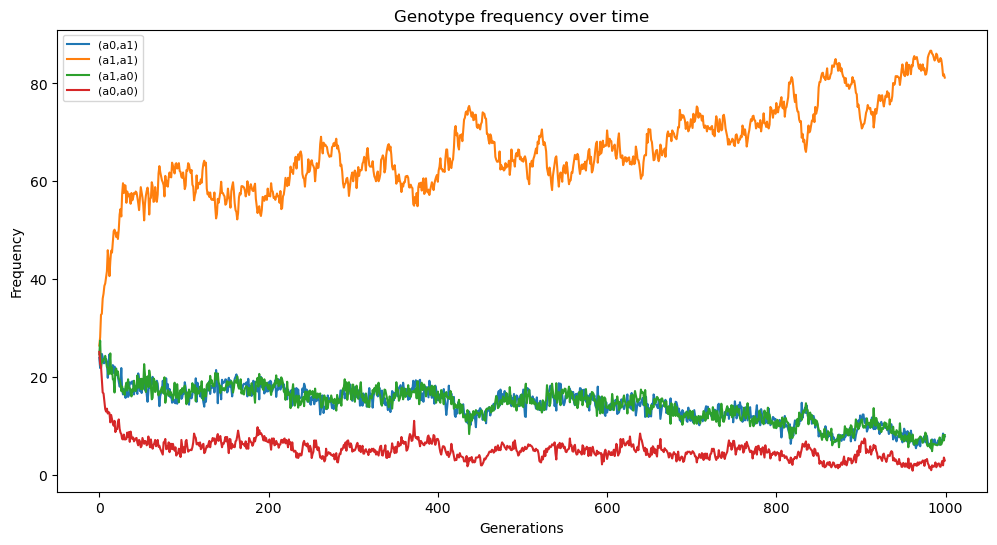

In [47]:
'''
What about when heterogenous genes are slightly better than the "good" homo gene?
------------------------------------------------------------
FINDINGS: 'good' homozy gene still prevails quickly, but 'bad' homozy gene doesn't die out completley
'''
unfitness_dict = {
    Genotype(0, (0,0)): 0.3,  # 00 quite bad
    Genotype(0, (1,0)): 0,  # 10 not bad
    Genotype(0, (0,1)): 0,  # 01 not bad
    Genotype(0, (1,1)): 0.1,  # 11 not bad
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=1000, simulations=10, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating)